# Experimental FLD scoring 

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

from peakqc.fld_scoring import *
import peakqc.insertsizes as ins

In [2]:
fragments_file = "/mnt/workspace2/jdetlef/data/public_data/fragments_heart_left_ventricle_194_sorted.bed"
h5ad_file = "/mnt/workspace2/jdetlef/data/public_data/heart_lv_SM-JF1NY.h5ad"
bamfile = "/mnt/workspace2/jdetlef/data/public_data/sorted_heart_left_ventricle_194.bam"

In [3]:
adata = sc.read_h5ad(h5ad_file)
adata_barcodes = adata.obs.index.tolist()

# split index for barcodes CBs
barcodes = []
for entry in adata_barcodes:
    barcode = entry.split('+')[1]
    barcodes.append(barcode)

In [4]:
adata.obs['stripped_barcodes'] = barcodes
adata.obs = adata.obs.set_index('stripped_barcodes')
adata_f = adata.copy()
adata_b = adata.copy()

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 17it [01:12,  4.24s/it]


Done reading file - elapsed time: 0:01:37
Converting counts to dataframe...
Done getting insertsizes from fragments!
plotting density...


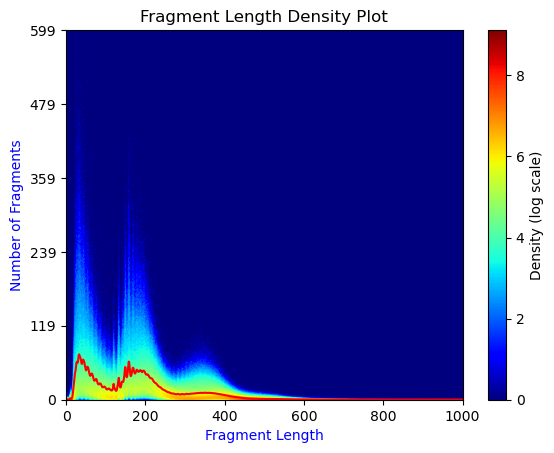

calculating scores using the custom continues wavelet transformation...


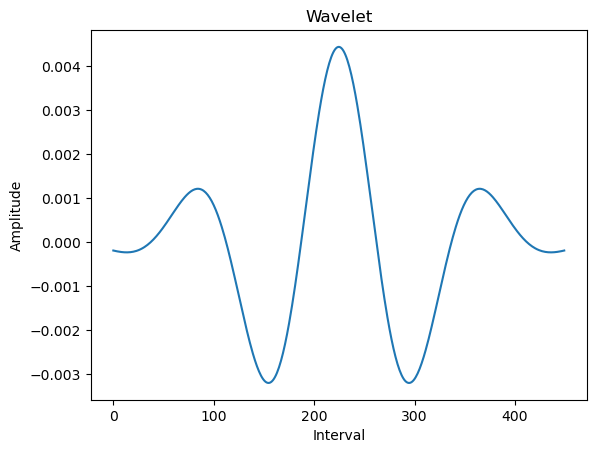

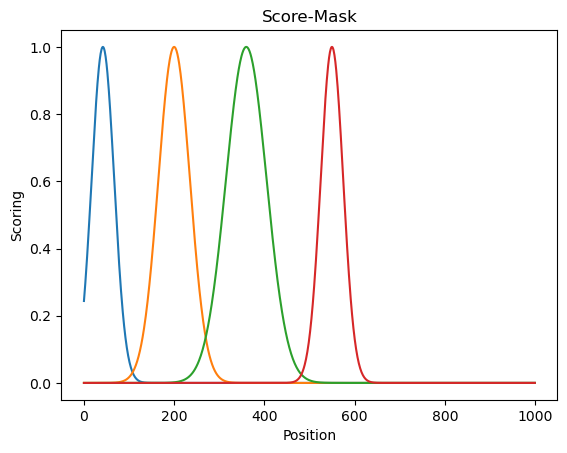

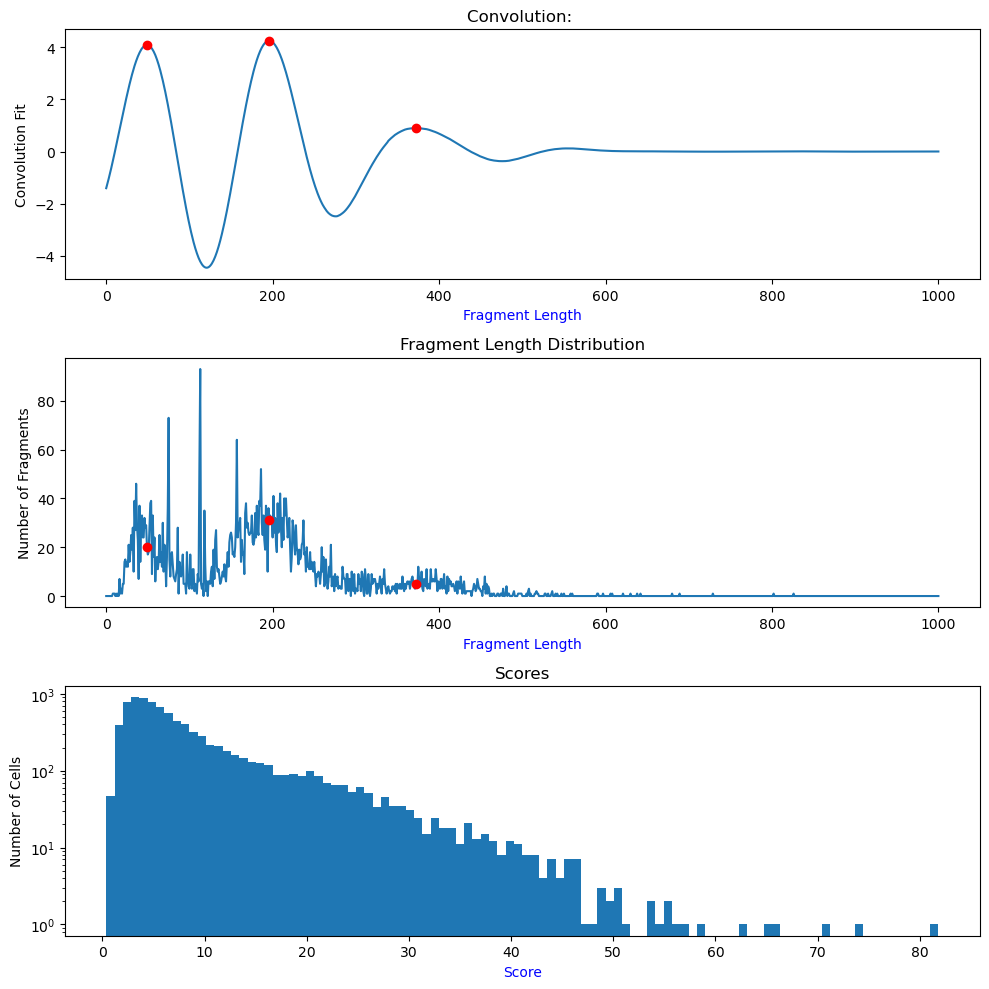

In [5]:
adata_f = add_fld_metrics(adata=adata_f,
                        fragments=fragments_file,
                        barcode_col=None,
                        chunk_size_fragments=5000000,
                        peaks_thr=0.5,
                        wavelength=150,
                        sigma=0.4,
                        plot=True,
                        save_density=None,
                        save_overview=None,
                        sample=0,
                        n_threads=12)

In [6]:
adata_f.obs

,logUMI,tsse,tissue,cell type,Life stage,closest Cell Ontology term(s),Cell Ontology ID,fld_score,mean_fragment_size,n_fragments
stripped_barcodes,,,,,,,,,,
TAGTGCTGTCTCGCTTAGCCTT,3.103119,15.499255,heart_lv_SM-JF1NY,Naive T cell,Adult,naive t cell,CL:0000898,1.122236,156.14,2104
AAATCCGCATAACCGCTAATGA,3.395326,10.463122,heart_lv_SM-JF1NY,Macrophage (General),Adult,macrophage,CL:0000235,3.200758,174.73,4213
AAATCCGCATACCAATCGCTTG,3.523876,13.254036,heart_lv_SM-JF1NY,Macrophage (General),Adult,macrophage,CL:0000235,4.865203,181.79,6414
AAATCCGCATACGCGGTATGTA,3.231979,10.817031,heart_lv_SM-JF1NY,Macrophage (General),Adult,macrophage,CL:0000235,2.402610,176.91,3797
AAATCCGCATATTAGGAGGTCT,3.202488,10.634648,heart_lv_SM-JF1NY,Macrophage (General),Adult,macrophage,CL:0000235,2.855965,194.39,2896
...,...,...,...,...,...,...,...,...,...,...
TACCGTACCTCAGACCTGCTCA,3.558709,9.710744,heart_lv_SM-JF1NY,Pericyte (General) 2,Adult,pericyte cell,CL:0000669,6.728133,193.34,6297
TAGACCAGGGCTTGCTGCCTAT,4.027431,7.671653,heart_lv_SM-JF1NY,Pericyte (General) 2,Adult,pericyte cell,CL:0000669,12.487313,166.00,19250
TATGTATGGCTTAGCTTCTCTG,3.456062,16.223776,heart_lv_SM-JF1NY,Pericyte (General) 2,Adult,pericyte cell,CL:0000669,5.358705,181.55,4939


In [ ]:
adata_b = add_fld_metrics(adata=adata_b,
                        bam=bamfile,
                        barcode_col=None,
                        barcode_tag="CB",
                        chunk_size_bam=1000000,
                        regions=None,
                        peaks_thr=0.5,
                        wavelength=150,
                        sigma=0.4,
                        plot=True,
                        save_density=None,
                        save_overview=None,
                        sample=0,
                        n_threads=12)

Opening bam file...
Creating chunks of size 1000000bp...
Counting insertsizes across 3103 chunks...


 77%|███████▋  | 2381/3103 [17:17<05:55,  2.03it/s]

In [ ]:
adata_b.obs

In [ ]:
count_table_ori = ins.insertsize_from_fragments(fragments=fragments_file,
                              barcodes=barcodes,
                              n_threads=8)

count_table = count_table_ori.copy()

In [ ]:
count_table = count_table_ori.copy()

In [ ]:
means = count_table.pop('mean_insertsize')
insert_counts = count_table.pop('insertsize_count')
barcodes = count_table.index
# Assuming count_table is your DataFrame and you're trying to convert 'dist' column to a numpy array of type int64
dists_arr = np.array(count_table['dist'].tolist(), dtype=np.int64)
dists_arr

In [ ]:
# --> Remove empty cells

In [ ]:
def count_overlap(index1, index2):
    """
    Counts the number of overlapping elements between two indices.
    
    Parameters:
    - index1: Index of the first DataFrame.
    - index2: Index of the second DataFrame.
    
    Returns:
    - int: The count of overlapping elements.
    """
    # Convert both indices to sets to ensure unique elements
    set1 = set(index1)
    set2 = set(index2)
    
    # Find the intersection of both sets
    overlap = set1.intersection(set2)
    
    # Return the size of the intersection
    return len(overlap)

In [ ]:
plot = True
save_plots = 'density_plot'
# plot the densityplot of the fragment length distribution
if plot:
    print("plotting density...")
    density_plot(dists_arr, max_abundance=600, save=save_plots)

In [ ]:
wavelength = 150
sigma = 0.4
plot=True
n_threads=8
peaks_thr=0.5
save_overview='ov_test'
sample=0


print("calculating scores using the custom continues wavelet transformation...")
conv_scores = score_by_conv(data=dists_arr,
                            wavelength=wavelength,
                            sigma=sigma,
                            plot_wavl=plot,
                            n_threads=n_threads,
                            peaks_thr=peaks_thr,
                            operator='bigger',
                            plot_mask=plot,
                            plot_ov=plot,
                            save=save_overview,
                            sample=sample)


In [ ]:
inserts_df = pd.DataFrame(data={'fld_score':conv_scores,
                                'mean_fragment_size': means,
                                'n_fragments':insert_counts},
                          index=barcodes)

inserts_df

In [ ]:
inserts_df.shape

In [ ]:
adata.obs.shape

In [ ]:
adata.obs = adata.obs.join(inserts_df)

adata.obs['fld_score'] = adata.obs['fld_score'].fillna(0)
adata.obs['mean_fragment_size'] = adata.obs['mean_fragment_size'].fillna(0)
adata.obs['n_fragments'] = adata.obs['n_fragments'].fillna(0)

In [ ]:
adata.obs